In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from math import ceil

import warnings
#warnings.filterwarnings("ignore")

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from random import randint

In [2]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

In [3]:
df_train = pd.read_csv("df_train_processed.csv")

In [4]:
df_train = df_train.drop(columns=['actor'])

In [5]:
df_train['emotional_intensity'].value_counts()

normal    984
strong    844
Name: emotional_intensity, dtype: int64

## Standardization

In [6]:
df_train_num = df_train.select_dtypes(include="number")
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [7]:
df_train_model = df_train

In [8]:
label_encoder = preprocessing.LabelEncoder()
df_train_model['emotional_intensity']= label_encoder.fit_transform(df_train_model['emotional_intensity'])

In [9]:
df_train_model = pd.get_dummies(df_train_model)

In [10]:
df_emotional_intensity_train = df_train_model

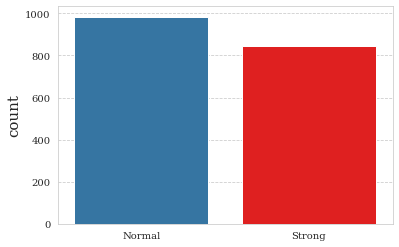

In [11]:
labels = ['Normal','Strong']
ax=sns.countplot(x=df_emotional_intensity_train['emotional_intensity'], palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
img_name = 'Before_Imbalancing_Emotional_Intensity' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [12]:
X = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns != 'emotional_intensity'])
    
y = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns == 'emotional_intensity'])

In [13]:
np.unique(y, return_counts=True)

(array([0, 1]), array([984, 844]))

In [14]:
import random
random.seed(2)
rows2remove = np.random.choice(df_emotional_intensity_train[y == 0].index, 984-35, replace=False)

In [15]:
df2 = df_emotional_intensity_train.drop(index=rows2remove, axis=0)
print(len(df2))

879


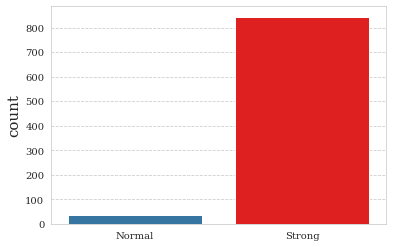

In [16]:
labels = ['Normal','Strong']
ax=sns.countplot(x=df2['emotional_intensity'], palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
img_name = 'After_Imbalancing_Emotional_Intensity' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [17]:
X2 = np.array(df2.loc[:, df2.columns != 'emotional_intensity'])
y2 = np.array([y[i] for i in range(len(y)) if i not in rows2remove]).ravel()

In [18]:
y2 = np.select([y2 == 1, y2 == 0], [0, 1], y2)

In [19]:
np.unique(y2, return_counts=True)        #majority class strong

(array([0, 1]), array([844,  35]))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=100)

In [21]:
X_train.shape

(615, 392)

In [22]:
def perform_tsne(X_data, y_data,img_name_prefix):
        
   
        X_reduced = TSNE(random_state=42).fit_transform(X_data)
     
        
       
        df = pd.DataFrame({'Dim 1':X_reduced[:,0], 'Dim 2':X_reduced[:,1] ,'label':y_data})
        
      
        
        sns.lmplot(data=df, x='Dim 2', y='Dim 1', hue='label', fit_reg=False, height=8,legend=False,
                   palette='Set1')
      
        plt.legend( loc='upper right', labels=['strong', 'normal'])
        img_name = img_name_prefix + '.png'
       
       
        #plt.savefig(img_name,dpi=300, bbox_inches='tight')
        plt.show()
        

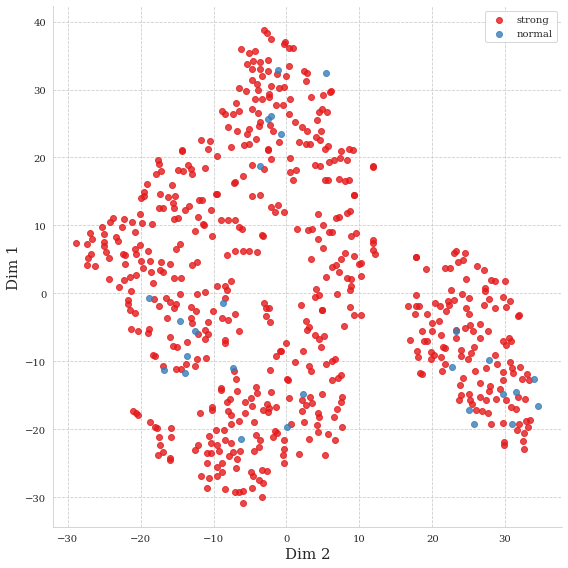

In [23]:
perform_tsne( X_train , y_train, 'Imbalance_Emotional_Intensity')

## Decision Tree before Undersampling/Oversampling

In [24]:
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import RepeatedStratifiedKFold

In [25]:
def Decision_tree(X_train_array, y_train_array):
    param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"],
    
}


    tree = DecisionTreeClassifier(random_state=42)


    tree_cv = RandomizedSearchCV(tree, param_grid, cv=RepeatedStratifiedKFold(n_splits=10,random_state=42),
    n_jobs=-1,
    n_iter=200)


    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv

In [26]:
decision_tree = Decision_tree(X_train, y_train)

In [27]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 0.006652051832712446, 'min_samples_split': 0.05758796000974105}


In [28]:
model_tree = DecisionTreeClassifier(criterion = 'entropy',
                                    max_depth = 6,
                                    min_samples_leaf = 0.006652051832712446, 
                                    min_samples_split = 0.05758796000974105)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6,
                       min_samples_leaf=0.006652051832712446,
                       min_samples_split=0.05758796000974105)

In [29]:
y_pred_decision_tree = model_tree.predict(X_test)

In [30]:
def metrics_model( test,predict, majority_class, minority_class):
    new_dic = {}
    new_dic['accuracy'] = accuracy_score(test,predict)
    #new_dic['precision ('+ majority_class + ')'] = precision_score(predict, test, average=None)[0]
    #new_dic['precision ('+ minority_class + ')'] = precision_score(predict, test,average=None)[1]
    #new_dic['recall ('+ majority_class + ')'] = recall_score(predict, test, average=None)[0]
    #new_dic['recall ('+ minority_class + ')'] = recall_score(predict, test, average=None)[1]
    new_dic['f1_score ('+ majority_class + ')'] = f1_score(test,predict, average=None)[0]
    new_dic['f1_score ('+ minority_class + ')'] = f1_score(test,predict, average=None)[1]
    
    return new_dic

In [31]:
data_decision_tree = metrics_model( y_test, y_pred_decision_tree, 'strong', 'normal')
data_decision_tree

{'accuracy': 0.9659090909090909,
 'f1_score (strong)': 0.9825918762088974,
 'f1_score (normal)': 0.18181818181818182}

In [32]:
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       256
           1       0.33      0.12      0.18         8

    accuracy                           0.97       264
   macro avg       0.65      0.56      0.58       264
weighted avg       0.95      0.97      0.96       264



## KNN before Undersampling/Oversampling

In [33]:
def spearman_selector(target, df, k):
    """Returns a df comprising all the features highly correlated (above k and below -k)
    with the binary target according Spearman coefficient. Target must be a pd Series"""
    df = df.select_dtypes(include="number")
    target = target.map({target.unique()[0]:0, target.unique()[1]:1})
    new_df = pd.DataFrame()
    for col in df:
        spearman = stats.spearmanr(df[col], target)[0]
        if spearman > k or spearman < -k:
            new_df[col] = df[col]
    return new_df

In [34]:
df_emotional_intensity_train_knn = spearman_selector(df_train['emotional_intensity'], 
                                           df_train, 0.4)

/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [35]:
df_train_cat_knn = df_train.select_dtypes(include=['object'])
df_emotional_intensity_train = pd.concat([df_emotional_intensity_train_knn, df_train_cat_knn], axis=1)

In [36]:
df_emotional_intensity_train = pd.get_dummies(df_emotional_intensity_train)

In [37]:
X3 = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns != 'emotional_intensity'])
    
y3 = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns == 'emotional_intensity'])

In [38]:
np.unique(y3, return_counts=True)

(array([0, 1]), array([984, 844]))

In [39]:
import random
random.seed(2)
rows2remove1 = np.random.choice(df_emotional_intensity_train[y == 0].index, 984-35, replace=False)

In [40]:
df3 = df_emotional_intensity_train.drop(index=rows2remove1, axis=0)
print(len(df3))

879


In [41]:
X4 = np.array(df3.loc[:, df3.columns != 'emotional_intensity'])
y4 = np.array([y[i] for i in range(len(y)) if i not in rows2remove1]).ravel()

In [42]:
np.unique(y4, return_counts=True)   #majority class strong

(array([0, 1]), array([ 35, 844]))

In [43]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X4, y4, test_size=0.3, random_state=100)

In [44]:
X_train_knn.shape

(615, 21)

In [45]:
def Knn(X_train_array, y_train_array):  
    
    knn = KNeighborsClassifier()
    
    parameters = {
        'n_neighbors': np.arange(2, X_train_array.shape[0]//2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'cityblock', 'minkowski']
        }
    
    knn_cv = RandomizedSearchCV(knn,
                     parameters,
                    cv=RepeatedStratifiedKFold(n_splits=10,random_state=42),
                    n_jobs=-1,
                    refit=True,random_state=24)
    
    knn_cv.fit(X_train_array, y_train_array)
    
    return knn_cv

In [46]:
knn = Knn(X_train_knn, y_train_knn)

In [47]:
print(knn.best_params_)

{'weights': 'uniform', 'n_neighbors': 211, 'metric': 'euclidean'}


In [48]:
model_knn = KNeighborsClassifier(weights = 'uniform',
                                 n_neighbors = 211, 
                                 metric = 'euclidean')
model_knn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(metric='euclidean', n_neighbors=211)

In [49]:
y_pred_knn = model_knn.predict(X_test_knn)

In [50]:
data_knn = metrics_model(y_test_knn, y_pred_knn, 'normal', 'strong')
data_knn

{'accuracy': 0.9545454545454546,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.9767441860465117}

In [51]:
print(classification_report(y_test_knn, y_pred_knn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.95      1.00      0.98       252

    accuracy                           0.95       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.91      0.95      0.93       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [52]:
def combined_results(data,data1):
    combined_dic = {'Decision_tree': data, 'Knn':data1}
    
    return combined_dic

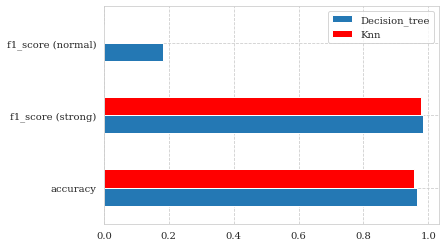

In [53]:
combined_dic = combined_results(data_decision_tree,data_knn)
df = pd.DataFrame(combined_dic)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('Imbalanced_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()

## Undersampling

## Random Undersampling

In [54]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

In [55]:
def randomUnderSampler(X_train_array, y_train_array):
    
    
    rus = RandomUnderSampler(random_state=42)
    
    X_res_rus, y_res_rus = rus.fit_resample(X_train_array, y_train_array)
    
    return X_res_rus, y_res_rus

In [56]:
X_res_rus, y_res_rus = randomUnderSampler(X_train, y_train)

In [57]:
X_res_rus_knn, y_res_rus_knn = randomUnderSampler(X_train_knn, y_train_knn)

In [58]:
print('Resampled dataset shape %s' % Counter(y_res_rus))

Resampled dataset shape Counter({0: 27, 1: 27})


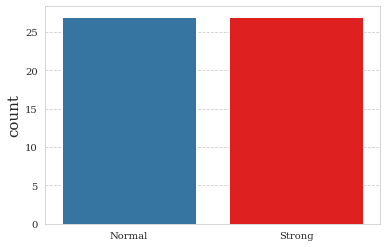

In [59]:
labels = ['Normal','Strong']
ax=sns.countplot(x=y_res_rus, palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
img_name = 'RandomUndersampling_Emotional_Intensity' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

## KNN after Random Undersampling

In [125]:
knn_under_rus = Knn(X_res_rus_knn, y_res_rus_knn)

In [126]:
print(knn_under_rus.best_params_)

{'weights': 'distance', 'n_neighbors': 13, 'metric': 'minkowski'}


In [127]:
model_knn_rus = knn_under_rus.best_estimator_
#model_knn_rus = KNeighborsClassifier(weights = 'distance', 
                                   #  n_neighbors = 13, 
                                   #  metric = 'minkowski')
model_knn_rus.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=13, weights='distance')

In [128]:
y_pred_knn_under_rus = model_knn_rus.predict(X_test_knn)

In [129]:
knn_rus = metrics_model(y_test_knn, y_pred_knn_under_rus, 'normal', 'strong')
knn_rus

{'accuracy': 0.9507575757575758,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.974757281553398}

In [130]:
print(classification_report(y_test_knn, y_pred_knn_under_rus))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.95      1.00      0.97       252

    accuracy                           0.95       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.91      0.95      0.93       264



## Decision Tree after Random Undersampling

In [66]:
decision_tree_under_rus = Decision_tree(X_res_rus, y_res_rus)

In [67]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_rus.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 26, 'min_samples_leaf': 0.0722597496695822, 'min_samples_split': 0.017423652214950604}


In [68]:
model_tree_rus = DecisionTreeClassifier(criterion = 'gini', 
                                        max_depth = 26, 
                                        min_samples_leaf = 0.0722597496695822,
                                        min_samples_split = 0.017423652214950604)
model_tree_rus.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=26, min_samples_leaf=0.0722597496695822,
                       min_samples_split=0.017423652214950604)

In [69]:
y_pred_decision_tree_under_rus = model_tree_rus.predict(X_test)

In [70]:
decision_tree_rus = metrics_model(y_test, y_pred_decision_tree_under_rus, 'strong', 'normal')
decision_tree_rus

{'accuracy': 0.9696969696969697,
 'f1_score (strong)': 0.9846153846153847,
 'f1_score (normal)': 0.0}

In [71]:
print(classification_report(y_test, y_pred_decision_tree_under_rus))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       256
           1       0.00      0.00      0.00         8

    accuracy                           0.97       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.94      0.97      0.95       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

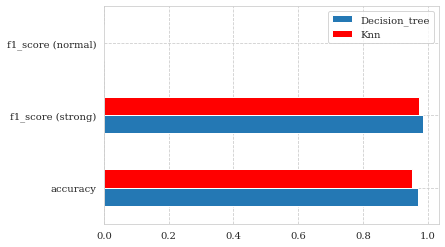

In [72]:
combined_dic_rus = combined_results(decision_tree_rus,knn_rus)
df = pd.DataFrame(combined_dic_rus)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.legend('loc=l', bbox_to_anchor=(0.6,0.5), labels=['Decision Tree', 'KNN'])
#plt.savefig('RandomUndersampling_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()

## Edited Nearest Neighbors

In [92]:
def enn(X_train_array, y_train_array):
    
    enn = EditedNearestNeighbours()
    
    X_res_enn, y_res_enn = enn.fit_resample(X_train_array, y_train_array)
    
    return X_res_enn, y_res_enn

In [93]:
X_res_enn, y_res_enn = enn(X_train, y_train)

In [94]:
X_res_enn_knn, y_res_enn_knn = enn(X_train_knn, y_train_knn)

In [95]:
print('Resampled dataset shape %s' % Counter(y_res_enn))

Resampled dataset shape Counter({0: 545, 1: 27})


## KNN after Edited Nearest Neighbors

In [96]:
knn_under_enn = Knn(X_res_enn_knn, y_res_enn_knn)

In [97]:
print(knn_under_enn.best_params_)

{'weights': 'distance', 'n_neighbors': 18, 'metric': 'minkowski'}


In [98]:
model_knn_enn = KNeighborsClassifier(weights = 'distance', 
                                     n_neighbors = 18,
                                     metric = 'minkowski')
model_knn_enn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=18, weights='distance')

In [99]:
y_pred_knn_under_enn = model_knn_enn.predict(X_test_knn)

In [100]:
knn_enn = metrics_model(y_test_knn,y_pred_knn_under_enn, 'normal', 'strong')
knn_enn

{'accuracy': 0.9507575757575758,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.974757281553398}

In [101]:
print(classification_report(y_test_knn, y_pred_knn_under_enn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.95      1.00      0.97       252

    accuracy                           0.95       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.91      0.95      0.93       264



## Decision Tree after Edited Nearest Neighbors

In [102]:
decision_tree_under_enn = Decision_tree(X_res_enn, y_res_enn)

In [103]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_enn.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'log_loss', 'max_depth': 116, 'min_samples_leaf': 0.004503807277356308, 'min_samples_split': 0.2555053561137974}


In [104]:
model_tree_enn = DecisionTreeClassifier(criterion = 'log_loss', 
                                        max_depth = 116, 
                                        min_samples_leaf = 0.004503807277356308, 
                                        min_samples_split = 0.2555053561137974)
model_tree_enn.fit(X_train, y_train)

DecisionTreeClassifier(criterion='log_loss', max_depth=116,
                       min_samples_leaf=0.004503807277356308,
                       min_samples_split=0.2555053561137974)

In [105]:
y_pred_decision_tree_under_enn = model_tree_enn.predict(X_test)

In [106]:
decision_tree_enn = metrics_model(y_test, y_pred_decision_tree_under_enn, 'strong', 'normal')
decision_tree_enn

{'accuracy': 0.9734848484848485,
 'f1_score (strong)': 0.9865125240847785,
 'f1_score (normal)': 0.2222222222222222}

In [107]:
print(classification_report(y_test, y_pred_decision_tree_under_enn))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       256
           1       1.00      0.12      0.22         8

    accuracy                           0.97       264
   macro avg       0.99      0.56      0.60       264
weighted avg       0.97      0.97      0.96       264



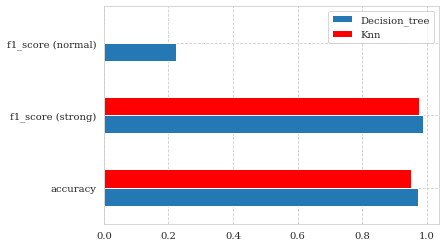

In [108]:
combined_dic_enn = combined_results(decision_tree_enn,knn_enn)
df = pd.DataFrame(combined_dic_enn)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('dddd',dpi=300, bbox_inches='tight')
plt.show()

## Oversampling

## SMOTE

In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
def smote(X_train_array, y_train_array):
    
    sm = SMOTE(random_state=42)
    
    X_res_sm, y_res_sm = sm.fit_resample(X_train_array, y_train_array)
    
    return X_res_sm, y_res_sm

In [75]:
X_res_sm_knn, y_res_sm_knn = smote(X_train_knn, y_train_knn)

In [76]:
X_res_sm, y_res_sm = smote(X_train, y_train)

In [77]:
print('Resampled dataset shape %s' % Counter(y_res_sm))

Resampled dataset shape Counter({0: 588, 1: 588})


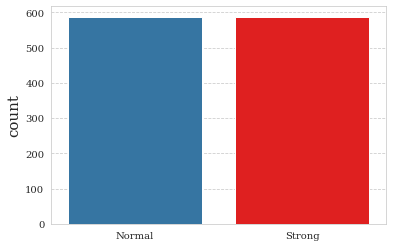

In [78]:
labels = ['Normal','Strong']
ax=sns.countplot(x=y_res_sm, palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
img_name = 'SMOTE_Emotional_Intensity' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

## KNN after SMOTE

In [118]:
knn_over_sm = Knn(X_res_sm_knn, y_res_sm_knn)

In [119]:
print(knn_over_sm.best_params_)

{'weights': 'distance', 'n_neighbors': 63, 'metric': 'euclidean'}


In [115]:
model_knn_smote = KNeighborsClassifier(weights = 'distance', 
                                       n_neighbors = 63, 
                                       metric = 'euclidean')
model_knn_smote.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(metric='euclidean', n_neighbors=63, weights='distance')

In [116]:
y_pred_knn_over_sm = model_knn_smote.predict(X_test_knn)

In [117]:
knn_smote = metrics_model(y_test_knn, y_pred_knn_over_sm, 'normal', 'strong')
knn_smote

{'accuracy': 0.9545454545454546,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.9767441860465117}

In [84]:
print(classification_report(y_test_knn, y_pred_knn_over_sm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.95      1.00      0.98       252

    accuracy                           0.95       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.91      0.95      0.93       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## Decision Tree after SMOTE

In [85]:
decision_tree_over_sm = Decision_tree(X_res_sm, y_res_sm)

In [86]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_over_sm.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 0.002255333581158191, 'min_samples_split': 0.027490729619718574}


In [87]:
model_tree_smote = DecisionTreeClassifier(criterion = 'gini', 
                                          max_depth = 50, 
                                          min_samples_leaf = 0.002255333581158191, 
                                          min_samples_split = 0.027490729619718574)
model_tree_smote.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, min_samples_leaf=0.002255333581158191,
                       min_samples_split=0.027490729619718574)

In [88]:
y_pred_decision_tree_over_sm = model_tree_smote.predict(X_test)

In [89]:
decision_tree_smote = metrics_model(y_test, y_pred_decision_tree_over_sm, 'strong', 'normal')
decision_tree_smote

{'accuracy': 0.9507575757575758,
 'f1_score (strong)': 0.9746588693957114,
 'f1_score (normal)': 0.13333333333333333}

In [90]:
print(classification_report(y_test, y_pred_decision_tree_over_sm))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       256
           1       0.14      0.12      0.13         8

    accuracy                           0.95       264
   macro avg       0.56      0.55      0.55       264
weighted avg       0.95      0.95      0.95       264



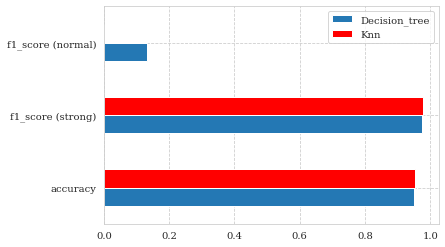

In [91]:
combined_dic_smote = combined_results(decision_tree_smote,knn_smote)
df = pd.DataFrame(combined_dic_smote)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.legend('loc=l', bbox_to_anchor=(0.6,0.5), labels=['Decision Tree', 'KNN'])
plt.savefig('SMOTE_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()